# BTC Prediction
12/17/18 Jonathan Cai  
Using sklearn models to make predictions on bitcoin data.

In [2]:
from datetime import timedelta, date, datetime
import requests
import io
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm, preprocessing

import seaborn as sns

from IPython.display import display
from matplotlib import style

Some plotting style...

In [3]:
style.use('ggplot')

## Data Extraction
Using [1Token.trade](https://1token.trade/) for the bitcoin data. Documentation for their api can be found [here](https://1token.trade/docs#/hist-quote/historical-data).

In [4]:
# 1Token's API address
tokenapi = 'http://hist-quote.1tokentrade.cn'

Run the following cell to extract token from `token.txt` in this same directory.  
Can replace this code with just `ot_key = "your 1Token API key"`

In [5]:
# Retrieve API token
current_path = os.getcwd()
with open(current_path + '/token.txt') as file:
    ot_key = file.read().splitlines()[0]

Querying 1Token's "candle" data.   
Currently looking at the contract 'binance/btx.usdt'.  
The max number of data points that 1Token allows in a single query is 15,000.

In [25]:
params = {
    'since' : '2018-12-11',
    'until' : '2018-12-21',
    'contract' : 'binance/btc.usdt',
    'duration' : '1m',
    'format' : 'csv'
}
r = requests.get(tokenapi + '/candles' , headers = {'ot-key' : ot_key}, params = params, stream = True)

df = pd.read_csv(io.StringIO(r.text))   
print("Number of data points:", len(df.index))
df.head()

Number of data points: 14400


,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


Write to a local file `btc-historical-data.csv`.

In [ ]:
df.to_csv(current_path + '/btc-historical-data.csv')

Let's visualize the dataset gathered...

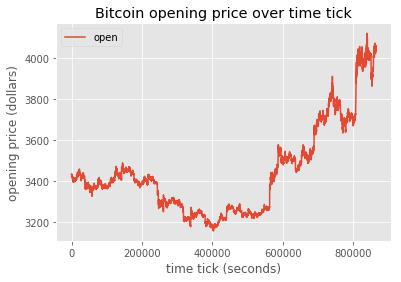

In [26]:
df_plot = df.drop(labels=['close', 'high', 'low', 'volume'], axis=1)
earliest_timestamp = df_plot['timestamp'][0]
df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp))
a = df_plot.plot(x = 'timestamp', y = 'open', \
                     title='Bitcoin opening price over time tick')
a.set_ylabel("opening price (dollars)")
a.set_xlabel("time tick (seconds)")
display(a)

## Data Preparation
We will reduce the features of our data down to `close`, `volume`, `hl_pct`, `pct_change`.  
`hl_pct` will stand for high-low percentage - the percent change between the high and low of a given tick.  
`pct_change` will stand for percent change - the percent change between open and close of a given tick.  
The logic behind this feature selection is that `hl_pct`, `pct_change`, and `volume` will be indicative of the volatility, while `close` will serve as the benchmark for the current time tick.   
The goal will be to predict the closing price `forecast_out` ticks away in order to derive the position one should take in the current time tick  
<!--I will be trying to predict the pct_change for a given tick. Positive pct_change will mean a long, negative pct_change will mean a short. -->

In [27]:
df_reduced = df.drop(labels=['timestamp'], axis=1)
df_reduced['hl_pct'] = (df_reduced['high'] - df_reduced['low']) / df_reduced['low'] * 100.0
df_reduced['pct_change'] = (df_reduced['close'] - df_reduced['open']) / df_reduced['open'] * 100.0
df_reduced = df_reduced.drop(labels=['high', 'low', 'open'], axis=1)

forecast_out = 60
forecast_col = 'close'
df_reduced['label'] = df_reduced[forecast_col].shift(-forecast_out)
df_reduced_nonan = df_reduced.dropna(inplace=False)
display(df_reduced_nonan.head())
display(df_reduced_nonan.tail())

,close,volume,hl_pct,pct_change,label
0,3433.40,19.362386,0.127899,-0.017763,3415.54
1,3425.85,49.151693,0.328562,-0.226292,3404.00
2,3423.26,9.487126,0.226685,-0.138273,3406.03
3,3425.19,10.325669,0.127937,0.019565,3406.50
4,3422.83,8.280380,0.120958,-0.069193,3406.35


,close,volume,hl_pct,pct_change,label
14335,4024.39,20.683896,0.134003,0.043752,4057.01
14336,4022.01,20.948302,0.146797,-0.021875,4052.22
14337,4026.32,40.810011,0.218164,0.033292,4052.09
14338,4045.43,47.263655,0.607370,0.475126,4055.36
14339,4043.51,108.259479,0.433078,-0.047214,4049.62


Now, the next step is to split the training/testing data.  
Preprocessing is unnecessary, but can be useful when scaling up.

In [11]:
percent_training = .8
X = np.array(df_reduced_nonan.drop(['label'], axis=1))
y = np.array(df_reduced_nonan['label'])
# X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - percent_training))
display(X_train.shape)
display(X_test.shape)

(11472, 4)

(2868, 4)

## Train/Test
Now, we can train linear regression model and check its accuracy.

In [12]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
accuracy

0.9809167931203197

We can also try regression using svm...

In [33]:
svm_clf = svm.SVR(kernel='linear', gamma='scale')
# svm_clf = svm.SVR(kernel='rbf', gamma='scale')
svm_clf.fit(X_train, y_train)
accuracy = svm_clf.score(X_test, y_test)
accuracy

0.9808753203569671

## Predicting Out
Now, we can try to predict the last `forecast_out` time ticks.  
Let's say `n = forecast_out`.  
From data preparation, because we shifted the labels by `n`, the last `n` rows had `NaN` as labels.  
Let's now plot our predictions for these last `n` ticks.  
We can use from the `len(data)-n-n`th tick to the `len(data)-n`th tick to predict the last `n` labels, which are currently `NaN`, to see the classifier in action?

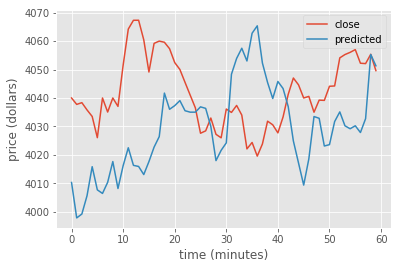

In [36]:
forecast_set = df_reduced[-forecast_out-forecast_out:-forecast_out]
predicted_set = clf.predict(forecast_set.drop('label', axis=1))
actual_set = df_reduced[-forecast_out:].drop(['volume', 'hl_pct', 'pct_change', 'label'], axis=1)
actual_set['index'] = np.arange(len(actual_set))
comparison = actual_set.set_index('index', inplace=False)
comparison['predicted'] = predicted_set


a = comparison.plot()
a.set_xlabel('time (minutes)')
a.set_ylabel('price (dollars)')
display(a)

No good!

In [30]:
comparison = forecast_set.drop(['volume', 'hl_pct', 'pct_change'], axis=1)
comparison['predicted_label'] = predicted_set
comparison['actual'] = comparison.apply(lambda row : 'long' if row['close'] < row['label'] else 'short', axis=1)
comparison['predicted'] = comparison.apply(lambda row : 'long' if row['close'] < row['predicted_label'] else 'short', axis=1)
display(comparison)
display(comparison['predicted'].values)

,close,label,predicted_label,actual,predicted
14280,4000.87,4040.00,4010.304206,long,long
14281,3990.98,4037.75,3997.846371,long,long
14282,3992.49,4038.36,3999.214356,long,long
14283,3998.00,4035.81,4005.635291,long,long
14284,4007.01,4033.51,4015.853712,long,long
14285,4001.00,4026.05,4007.705952,long,long
14286,4000.00,4040.00,4006.452786,long,long
14287,3999.95,4035.06,4010.356170,long,long
14288,4010.00,4040.00,4017.656733,long,long
14289,4001.35,4037.05,4008.181788,long,long


array(['long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long'], dtype=object)

If the closing price in the future is higher, this should indicate a "long" position, and if it is lower, this should indicate a "short" position.  
I've labeled what the position should be according to the actual future price under "actual" and what the position should be according to the model's prediction under "predicted".  
The LinearRegression model is predicting long for every time tick!

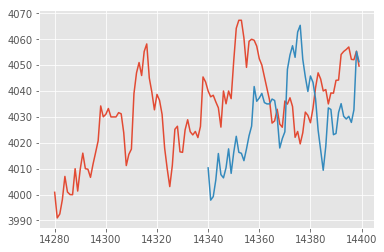

In [31]:
predicted_series = pd.Series(predicted_set, index=actual_set.index)
df_reduced['close'].drop(np.arange(len(df_reduced))[:-120]).plot()
predicted_series.plot()

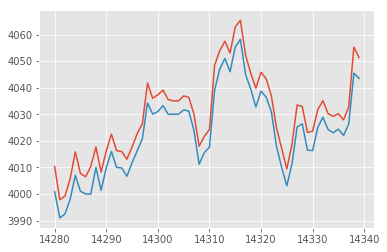

In [32]:
shifted_predicted_series = predicted_series.copy()
shifted_predicted_series.index = predicted_series.index - 60
shifted_predicted_series.plot()
df_reduced['close'][-120:-60].plot()

By shifting back our predictions exactly 60 timeticks, we see that the predictions at `y_t` tightly match the price at `y_t-60`.  
This is the exact flaw pointed out in [this Hacker Noon article](https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151) - the model is based on historical prices alone, likely causing its ineffectiveness. Also, the features of our data set are "close", "volume", "hl_pct", and "pct_change". Other than "close" which is closing price, none seem intuitively predictive of a future closing price. I would guess that a more effective model would incorporate more features (like market sentiment), and would be more complicated than simple linear regression. 

# Moving Forward...
12/21/18  
Let's try something different, and with more data?

Trying to extracting more data:

The following cell retrieves [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/) data.    
Data is on a day interval, from bitcoin's inception until December 2018.

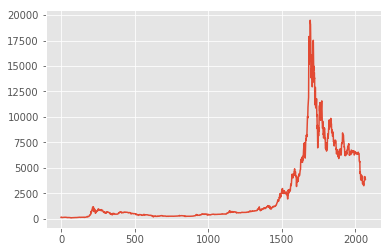

In [75]:
df = pd.read_csv(current_path + '/coinmarketcap.csv')
df.index = list(df.index)[::-1]
df['Close'].apply(lambda x : float(x.replace(',',''))).plot()

The following cells retrieves more 1token data, still restricted by the limit on their API.

In [11]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days))[::10]:
        yield start_date + timedelta(n)
        
days_ago = 100
today = datetime.today()
start_date = (today - timedelta(days_ago)).date()
end_date = today.date()
print("Getting data between %s, and %s." % (start_date, end_date))
dates = list(daterange(start_date, end_date))
dates.append(end_date)
print(np.array(dates))

# Average call for 10 days, 1 min tick is 72 quota expense... quota limit around 700?

# Must use fake user-agent for iterating requests
headers = {
    'user-agent': ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5)'
                          'AppleWebKit/537.36 (KHTML, like Gecko)'
                          'Chrome/45.0.2454.101 Safari/537.36'),
    'referer': 'http://stats.nba.com/scores/',
    'ot-key' : ot_key
}

# Use template parameters object
params = {
    'since' : 'will be replaced with actual date',
    'until' : 'will be replaced with actual date',
    'contract' : 'binance/btc.usdt',
    'duration' : '1m',
    'format' : 'csv'
}

# Accumulate a large DataFrame for all requests 
df = pd.DataFrame()
# Itererate through all date intervals
for idx in range(len(dates) - 1):
    params['since'] = str(dates[idx])
    params['until'] = str(dates[idx + 1])
    r = requests.get(tokenapi + '/candles' , headers=headers, params=params, stream = True)
    print("Recieved response #" + str(idx) + ": " + params['since'] + ' to ' + params['until'])
    single_df = pd.read_csv(io.StringIO(r.text)).set_index('timestamp')
    df = pd.concat([df, single_df])
    if int(r.headers['ot-quota-remaining']) < 72:
        print("Reached ot-quota limit!")
        break
    
df.sort_index()
df.tail()

Getting data between 2018-09-21, and 2018-12-30.
[datetime.date(2018, 9, 21) datetime.date(2018, 10, 1)
 datetime.date(2018, 10, 11) datetime.date(2018, 10, 21)
 datetime.date(2018, 10, 31) datetime.date(2018, 11, 10)
 datetime.date(2018, 11, 20) datetime.date(2018, 11, 30)
 datetime.date(2018, 12, 10) datetime.date(2018, 12, 20)
 datetime.date(2018, 12, 30)]
Recieved response #0 : {'since': '2018-09-21', 'until': '2018-10-01', 'contract': 'binance/btc.usdt', 'duration': '1m', 'format': 'csv'}
Recieved response #1 : {'since': '2018-10-01', 'until': '2018-10-11', 'contract': 'binance/btc.usdt', 'duration': '1m', 'format': 'csv'}
Recieved response #2 : {'since': '2018-10-11', 'until': '2018-10-21', 'contract': 'binance/btc.usdt', 'duration': '1m', 'format': 'csv'}
Recieved response #3 : {'since': '2018-10-21', 'until': '2018-10-31', 'contract': 'binance/btc.usdt', 'duration': '1m', 'format': 'csv'}
Recieved response #4 : {'since': '2018-10-31', 'until': '2018-11-10', 'contract': 'binance

,close,high,low,open,volume
timestamp,,,,,
1546127700,3703.00,3707.18,3692.88,3694.99,58.039220
1546127760,3703.77,3710.00,3700.95,3703.61,61.523442
1546127820,3694.50,3704.65,3690.00,3704.65,87.155646
1546127880,3689.54,3696.96,3683.88,3694.50,138.169163
1546127940,3695.32,3696.82,3680.00,3689.51,176.499026


In [15]:
df.to_csv(current_path + '/btc-historical-data.csv')

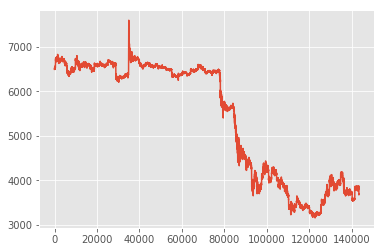

In [17]:
df = pd.read_csv(current_path + '/btc-historical-data.csv')
df['close'].plot()

In [22]:
df_reduced = df.drop(labels=['timestamp'], axis=1)
df_reduced['hl_pct'] = (df_reduced['high'] - df_reduced['low']) / df_reduced['low'] * 100.0
df_reduced['pct_change'] = (df_reduced['close'] - df_reduced['open']) / df_reduced['open'] * 100.0
df_reduced = df_reduced.drop(labels=['high', 'low', 'open'], axis=1)

forecast_out = 60
forecast_col = 'close'
df_reduced['label'] = df_reduced[forecast_col].shift(-forecast_out)
df_reduced_nonan = df_reduced.dropna(inplace=False)
display(df_reduced_nonan.head())
display(df_reduced_nonan.tail())

,close,volume,hl_pct,pct_change,label
0,6497.99,21.059118,0.123248,0.092267,6512.73
1,6515.97,79.013693,0.314271,0.283028,6511.90
2,6512.93,9.950203,0.122773,0.015817,6511.02
3,6521.72,59.544785,0.215755,0.149109,6503.50
4,6514.73,66.991024,0.198785,-0.107640,6501.50


,close,volume,hl_pct,pct_change,label
143305,3849.31,15.738544,0.142008,0.115999,3703.00
143306,3847.16,18.986870,0.132630,-0.045208,3703.77
143307,3848.78,16.884088,0.198942,0.089459,3694.50
143308,3849.31,12.243546,0.145553,-0.015585,3689.54
143309,3846.82,23.168863,0.085283,-0.054041,3695.32


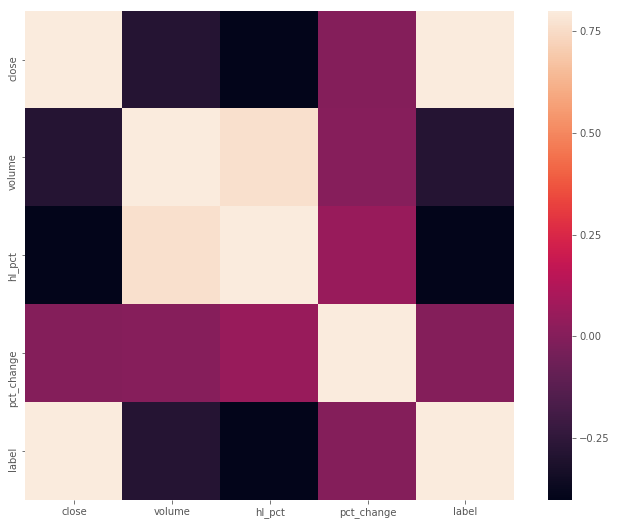

In [23]:
corrmat = df_reduced_nonan.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

By the above correlation heatmap, it's clear that the `volume`, `hl_pct` features are not very correlated with the pricing labels. Future models probably should not contain these feature, and maybe not even `pct_change`. It only leaves `close`, correlating strongly with `label`, which validates my previous assumptions that the model's predictions were highly, if not *completely* dependant on the current closing price. Lesson learned - understand the data a lot better before trying to model.